In [ ]:
# Import required libraries
from fastai.vision.all import *
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

# Download and extract Imagenette dataset
path = untar_data(URLs.IMAGENETTE)
print(f"Dataset path: {path}")

# Define a DataBlock with data augmentation
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(256),
    batch_tfms=[
        *aug_transforms(size=224, max_rotate=15, max_zoom=1.2, max_warp=0.2, max_lighting=0.3),
        Normalize.from_stats(*imagenet_stats)
    ]
)

Dataset path: /root/.fastai/data/imagenette2


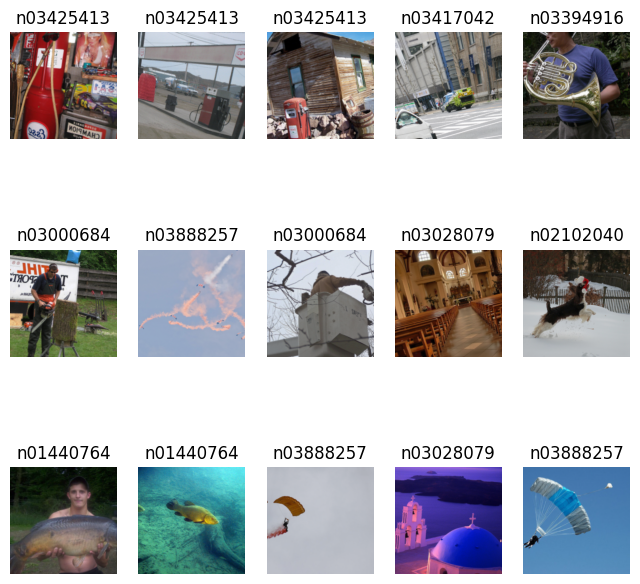

In [ ]:
# Create DataLoaders
dls = dblock.dataloaders(path, bs=64)

# Display sample images
dls.show_batch(max_n=15, figsize=(8, 8))


In [ ]:
# Load AlexNet model and modify for Imagenette
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[-1] = nn.Linear(alexnet.classifier[-1].in_features, dls.c)

# Define Learner with advanced settings
learn = Learner(
    dls,
    alexnet,
    metrics=[accuracy],
    loss_func=LabelSmoothingCrossEntropy(),
    cbs=[
        SaveModelCallback(monitor='accuracy', comp=np.greater),
        EarlyStoppingCallback(monitor='accuracy', patience=3)
    ]
).to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 155MB/s]


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,1.317823,0.763801,0.924586,01:36
1,1.224006,0.791311,0.914650,01:31
2,1.201959,0.780868,0.907261,01:30
3,1.176018,0.760584,0.913376,01:32


Better model found at epoch 0 with accuracy value: 0.9245859980583191.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.762128,0.748167,0.911083,01:32
1,0.878332,0.902487,0.863440,01:32
2,1.045107,1.022830,0.823185,01:33
3,1.040714,0.983641,0.824968,01:33


Better model found at epoch 0 with accuracy value: 0.9110828042030334.
No improvement since epoch 0: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

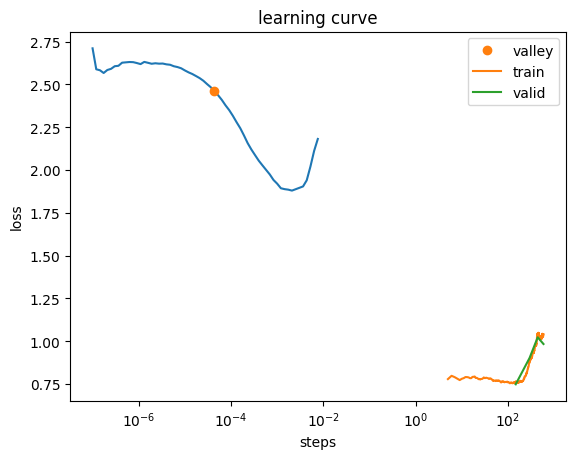

In [ ]:
# Find the optimal learning rate
learn.lr_find()

# Train the model with one cycle policy and mixup
learn.fit_one_cycle(10, 3e-4, cbs=[MixUp()])

# Unfreeze the model and fine-tune
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-5, 1e-3))

# Plot training metrics
learn.recorder.plot_loss()


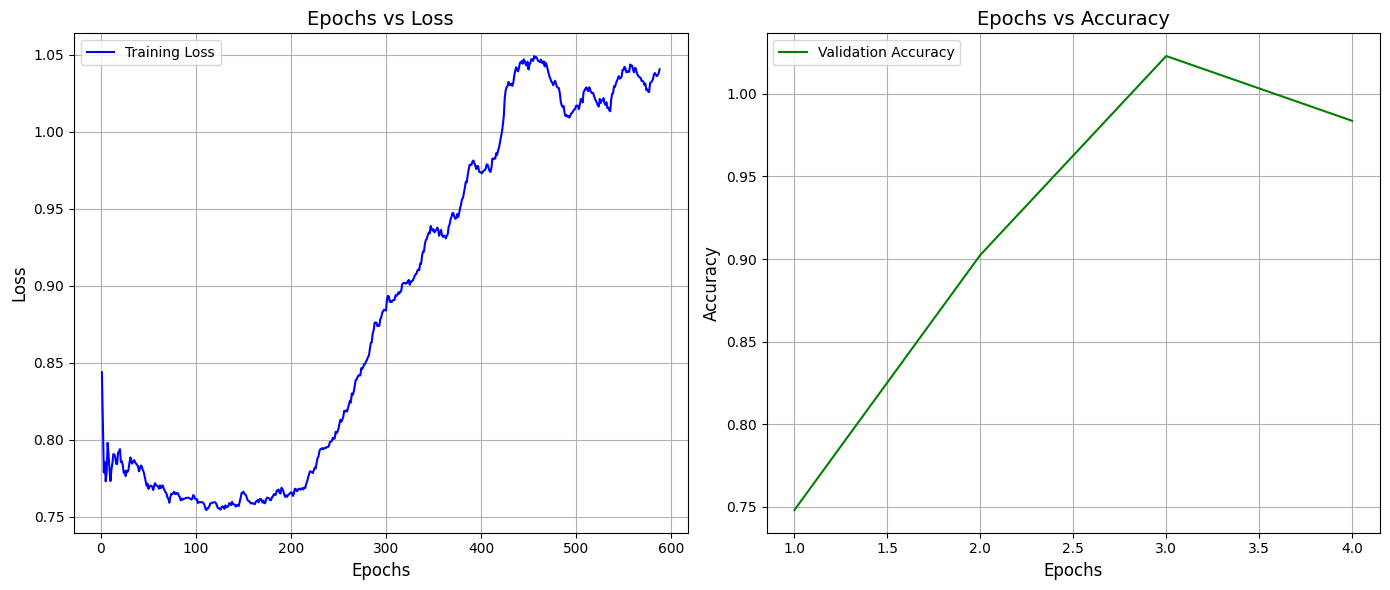

In [ ]:
# Plot Epochs vs Loss and Epochs vs Accuracy
train_losses = [float(loss) for loss in learn.recorder.losses]
train_epochs = list(range(1, len(train_losses) + 1))
val_accuracies = [x[1] for x in learn.recorder.values]

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, label="Training Loss", color="blue")
plt.title("Epochs vs Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_epochs[:len(val_accuracies)], val_accuracies, label="Validation Accuracy", color="green")
plt.title("Epochs vs Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the validation set with TTA
preds, targets = learn.tta()
pred_labels = preds.argmax(dim=1)

# Generate a classification report
report = classification_report(targets, pred_labels, target_names=dls.vocab, digits=4)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

   n01440764     0.9552    0.9922    0.9734       387
   n02102040     1.0000    0.9367    0.9673       395
   n02979186     0.7099    0.9804    0.8235       357
   n03000684     0.9138    0.7694    0.8354       386
   n03028079     0.9724    0.9462    0.9591       409
   n03394916     0.9481    0.9264    0.9371       394
   n03417042     0.8928    0.9203    0.9063       389
   n03425413     0.9094    0.7422    0.8173       419
   n03445777     0.9139    0.9574    0.9351       399
   n03888257     0.9488    0.9513    0.9501       390

    accuracy                         0.9108      3925
   macro avg     0.9164    0.9123    0.9105      3925
weighted avg     0.9185    0.9108    0.9109      3925



/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Accuracy on 10 random images: 90.00%


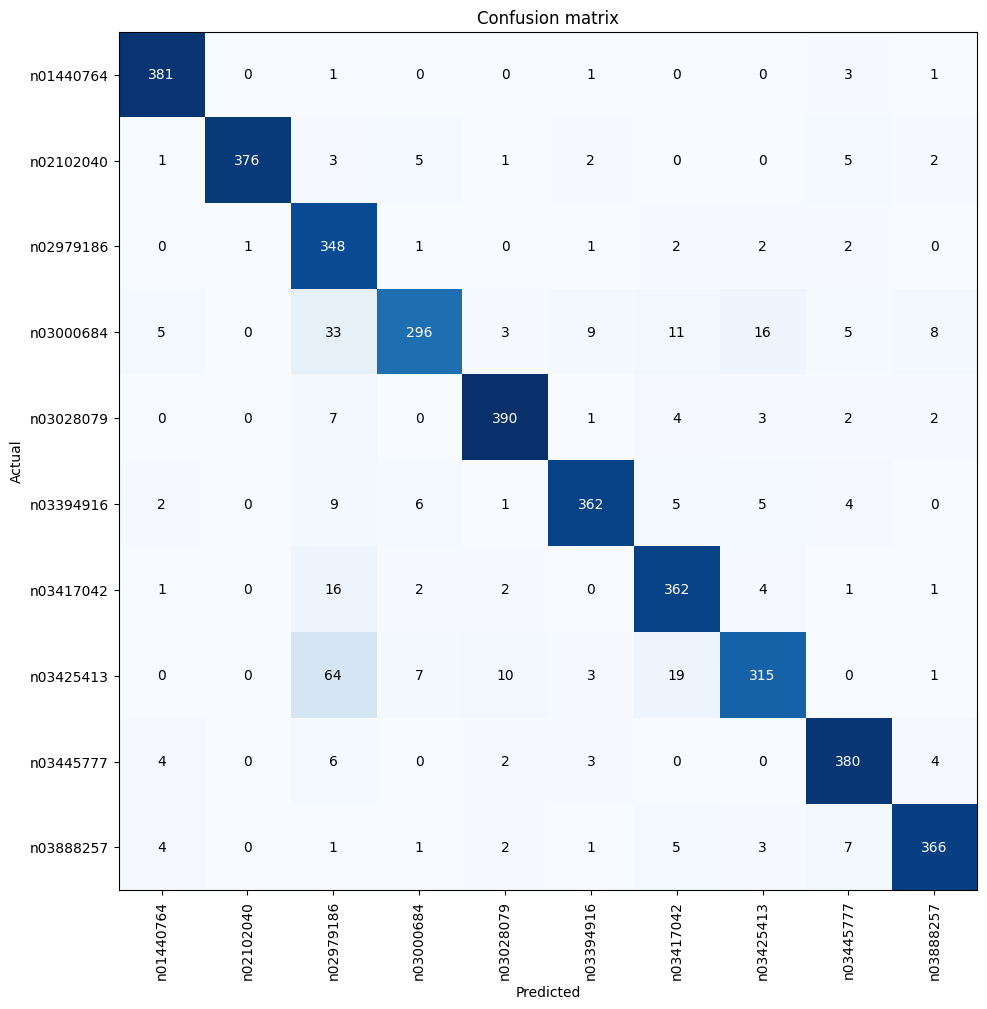

In [ ]:
# Display confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), cmap='Blues')

# Test on 10 random validation images
valid_dl = dls.valid
sample_indices = random.sample(range(len(valid_dl.dataset)), 10)

images = []
labels = []
for idx in sample_indices:
    img, lbl = valid_dl.dataset[idx]
    images.append(img)
    labels.append(lbl)

model_preds = []
for img in images:
    pred, _, _ = learn.predict(img)
    model_preds.append(pred)

correct = sum(
    [pred == dls.vocab[actual_idx] for pred, actual_idx in zip(model_preds, labels)]
)
accuracy = correct / len(labels)

print(f"Accuracy on 10 random images: {accuracy * 100:.2f}%")

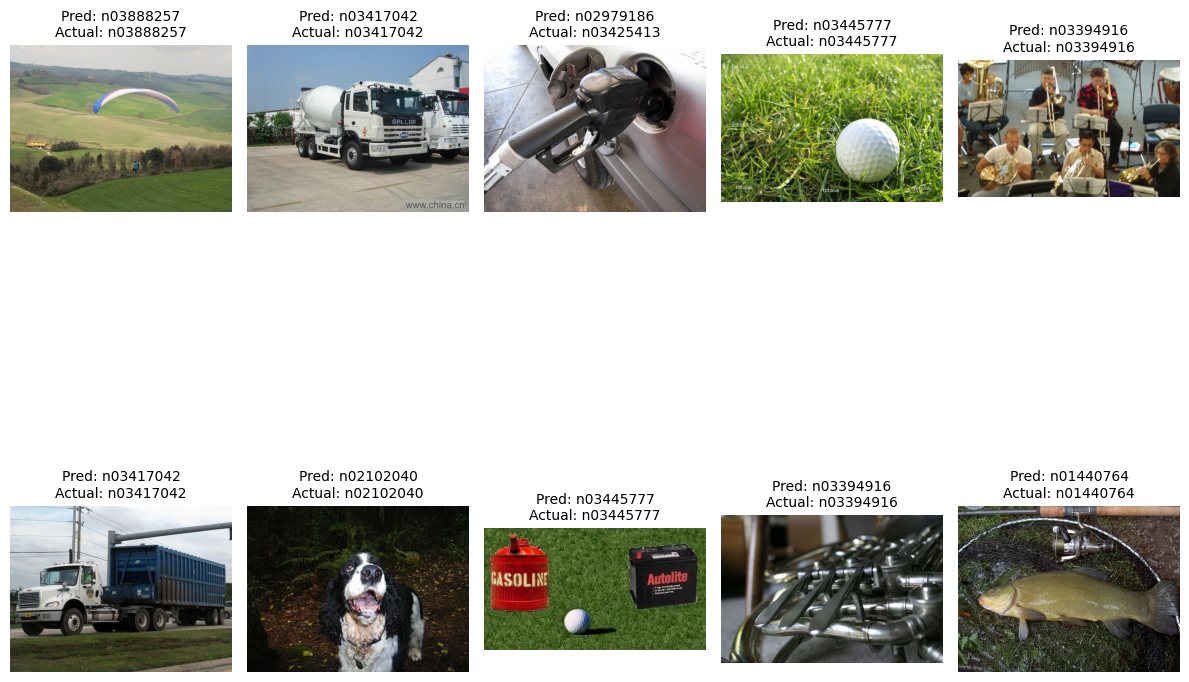

In [ ]:
# Display the images with their predicted and actual labels
plt.figure(figsize=(12, 12))
for i, img in enumerate(images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {model_preds[i]}\nActual: {dls.vocab[labels[i]]}", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


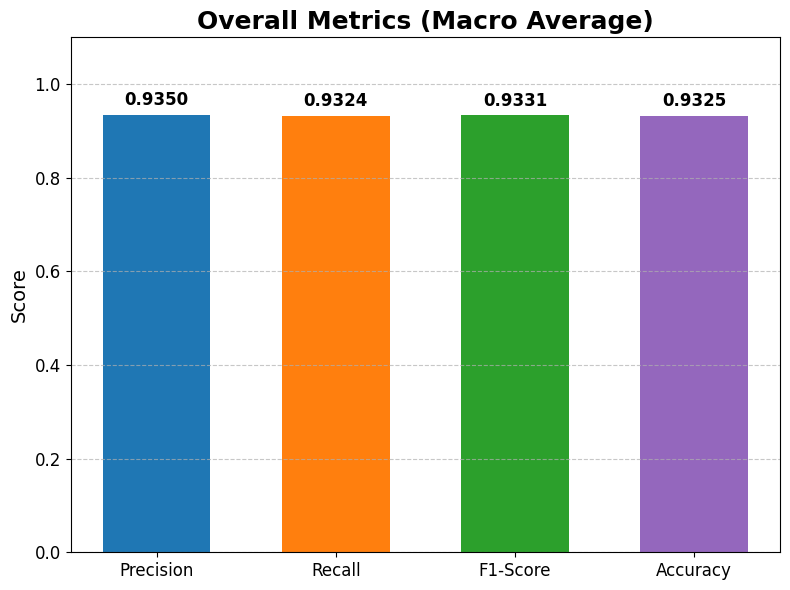

In [ ]:
import matplotlib.pyplot as plt

# Overall Metrics (Macro Average)
overall_metrics = [0.9350, 0.9324, 0.9331, 0.9325]  # Precision, Recall, F1-Score, Accuracy
metrics_labels = ["Precision", "Recall", "F1-Score", "Accuracy"]

# Custom color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]  # Blue, Orange, Green, Purple

plt.figure(figsize=(8, 6))

# Bar plot for overall metrics
plt.bar(metrics_labels, overall_metrics, color=colors, width=0.6)

# Adding labels and title
plt.title("Overall Metrics (Macro Average)", fontsize=18, weight="bold")
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1.1)  # Limit to 1.1 for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add text annotations on bars
for i, value in enumerate(overall_metrics):
    plt.text(i, value + 0.02, f"{value:.4f}", ha="center", fontsize=12, weight="bold")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
print(learn.model)
print(learn.summary())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 55 x 55   
Conv2d                                    23296      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 27 x 27   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 192 x 27 x 27  
Conv2d                                    307392     True      
ReLU                                                           
____________________________________________________________________________
                     64 x 192 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 384 x 13